# Packages

In [ ]:
# Data analysis
import scanpy as sc
import cellrank as cr
from moscot.problems.time import TemporalProblem
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec

# Utilities
import gc

# Functions

In [ ]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=None,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if size is None:
        size = 150000/adata.n_obs

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

# Setup

## Loading

In [ ]:
data_path = '/path/to/data/'

adata = sc.read_h5ad(f"{data_path}detc_cleaned.h5ad")

## Colors

In [ ]:
colors_hex = ['#8c510a','#bf812d','#dfc27d','#c7eae5','#80cdc1','#35978f','#01665e']
timepoint_colors = {
    key: colors_hex[i] for i, key in enumerate(adata.obs['timepoint'].cat.categories)
}

In [ ]:
colors_hex = [
    '#66c5cc','#f6cf71','#f89c74',
    '#dcb0f2','#87c55f','#9eb9f3',
    '#fe88b1','#c9db74','#8be0a4',
    '#b497e7','#d3b484','#b3b3b3',
    '#89fade','#817157','#132b58'
]
leiden_colors = {
    f'{i}': colors_hex[i] for i in range(15)
}

# PAGA

In [ ]:
sc.tl.paga(
    adata,
    groups = 'leiden'
)

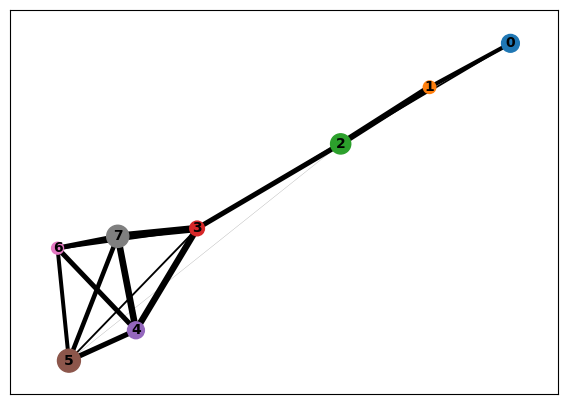

In [ ]:
sc.pl.paga(
    adata,
    color = 'leiden'
)

In [ ]:
sc.pl.umap(
    adata,
    color='timepoint',
    palette = timepoint_colors
)

In [ ]:
sc.tl.draw_graph(adata, init_pos='paga')

# Cellrank

## Kernels

### RealTimeKernel

#### Moscot

In [ ]:
adata.obs["timepoint_num_cat"] = adata.obs["timepoint"].map(
    {key: i for i, key in enumerate(adata.obs["timepoint"].cat.categories)}
)

adata.obs["timepoint_num"] = adata.obs["timepoint_num_cat"].astype("float")

In [ ]:
tp = TemporalProblem(adata)

In [ ]:
tp = tp.score_genes_for_marginals(
    gene_set_proliferation='mouse', gene_set_apoptosis='mouse'
)

       'Rps27l'],
      dtype='object')


In [ ]:
tp = tp.prepare(time_key='timepoint_num_cat')

INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                                                                                                                                                                                                                                                                                          
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                                                                                                                                                                                                                                                                                          
INFO     Computing pca with `n_comps=30` for `xy` using `adata.X`                                                                                                                                                                               

In [ ]:
tp = tp.solve(epsilon=1e-3, tau_a=0.95, scale_cost="mean")

INFO     Solving `6` problems                                                                                                                                                                                                                                                                                                                                                              
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1662, 2471)].                                                                                                                                                                                                                                                                                                          


INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(2471, 3176)].                                                                                                                                                                                                                                                                                                          
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(1472, 2765)].                                                                                                                                                                                                                                                                                                          
INFO     Solving problem BirthDeathProblem[stage='prepared', shape=(3176, 1472)].                                                                                                                                                               

In [ ]:
tmk = cr.kernels.RealTimeKernel.from_moscot(tp)

In [ ]:
tmk.compute_transition_matrix(self_transitions='all', conn_weight=0.2)

100%|██████████| 6/6 [00:00<00:00, 70295.60time pair/s]


RealTimeKernel[n=25911, threshold='auto', self_transitions='all']

### Connectivity kernel

In [ ]:
ck = cr.kernels.ConnectivityKernel(adata)

In [ ]:
ck.compute_transition_matrix()

ConnectivityKernel[n=25911, dnorm=True, key='connectivities']

### Combined Kernel

In [ ]:
combined_kernel = 0.99*tmk + 0.01*ck

In [ ]:
combined_kernel.compute_transition_matrix()

(0.99 * RealTimeKernel[n=25911, threshold='auto', self_transitions='all'] + 0.01 * ConnectivityKernel[n=25911, dnorm=True, key='connectivities'])

## Estimators

### GPCCA

In [ ]:
g = cr.estimators.GPCCA(combined_kernel)

print(g)

GPCCA[kernel=(0.99 * RealTimeKernel[n=25911] + 0.01 * ConnectivityKernel[n=25911]), initial_states=None, terminal_states=None]


/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


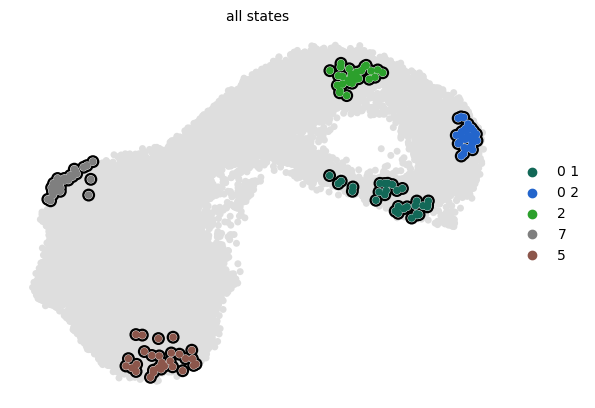

In [ ]:
g.fit(cluster_key="leiden", n_states=[4, 13])
g.plot_macrostates(which="all", discrete=True, legend_loc="right", s=100)

/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


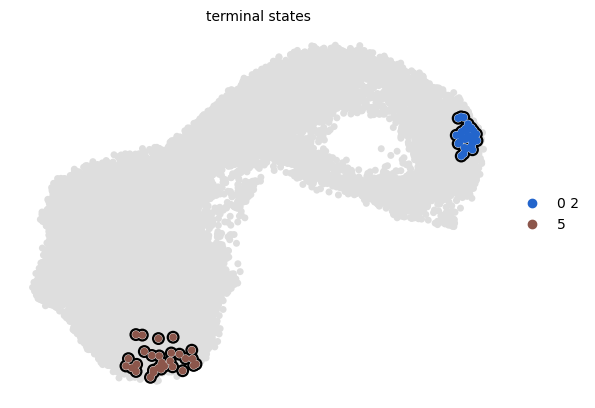

In [ ]:
g.predict_terminal_states()
g.plot_macrostates(which="terminal", legend_loc="right", s=100)

/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:656: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  smp = ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/scatter.py:694: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1396: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=bg_size, marker=".", c=bg_color, zorder=zord - 2, **kwargs)
/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scvelo/plotting/utils.py:1397: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, s=gp_size, marker=".", c=gp_color, zorder=zord - 1, **kwargs)


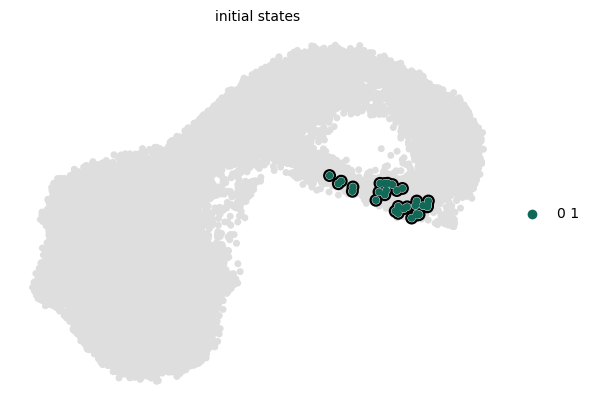

In [ ]:
g.predict_initial_states()
g.plot_macrostates(which="initial", legend_loc="right", s=100)

100%|██████████| 2/2 [00:00<00:00,  2.38/s]


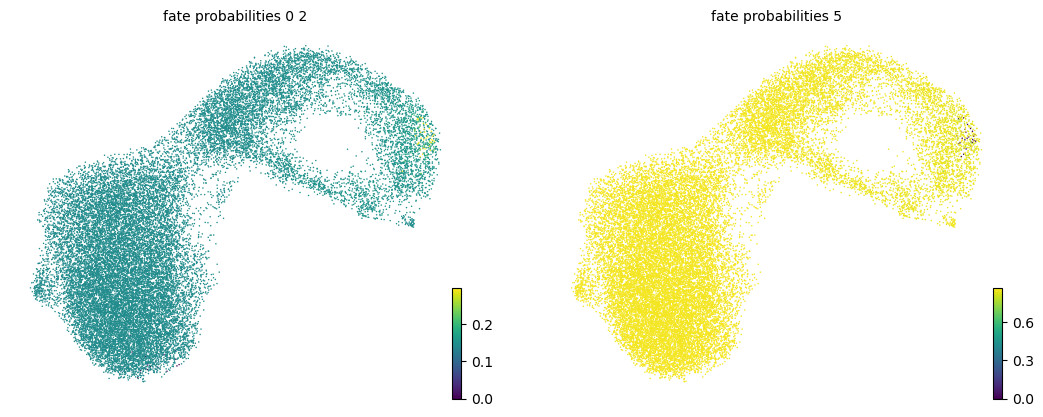

In [ ]:
g.compute_fate_probabilities(tol=1e-12)
g.plot_fate_probabilities(same_plot=False)

In [ ]:
adata.X = adata.layers['log1p_norm'].copy()

### Pseudotime

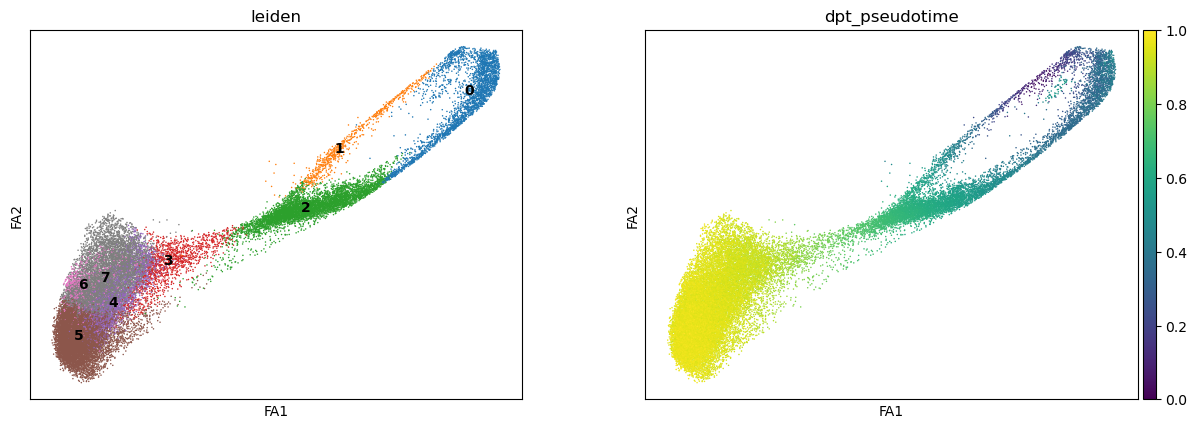

In [ ]:
adata.uns['iroot'] = np.flatnonzero(adata.obs['init_states_fwd'] == '0_1')[0]

sc.tl.dpt(adata)
sc.pl.draw_graph(adata, color=["leiden", "dpt_pseudotime"], legend_loc="on data")

### Gene expression trends

In [ ]:
model = cr.models.GAM(adata, n_knots=10, )

 95%|█████████▍| 1892/2000 [16:05<03:00,  1.68s/gene] 

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


 96%|█████████▌| 1911/2000 [16:22<01:20,  1.10gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


 97%|█████████▋| 1941/2000 [16:45<00:20,  2.95gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


 98%|█████████▊| 1961/2000 [16:56<00:22,  1.74gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


100%|█████████▉| 1997/2000 [17:49<00:00,  3.44gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


100%|██████████| 2000/2000 [18:02<00:00,  1.85gene/s]


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.


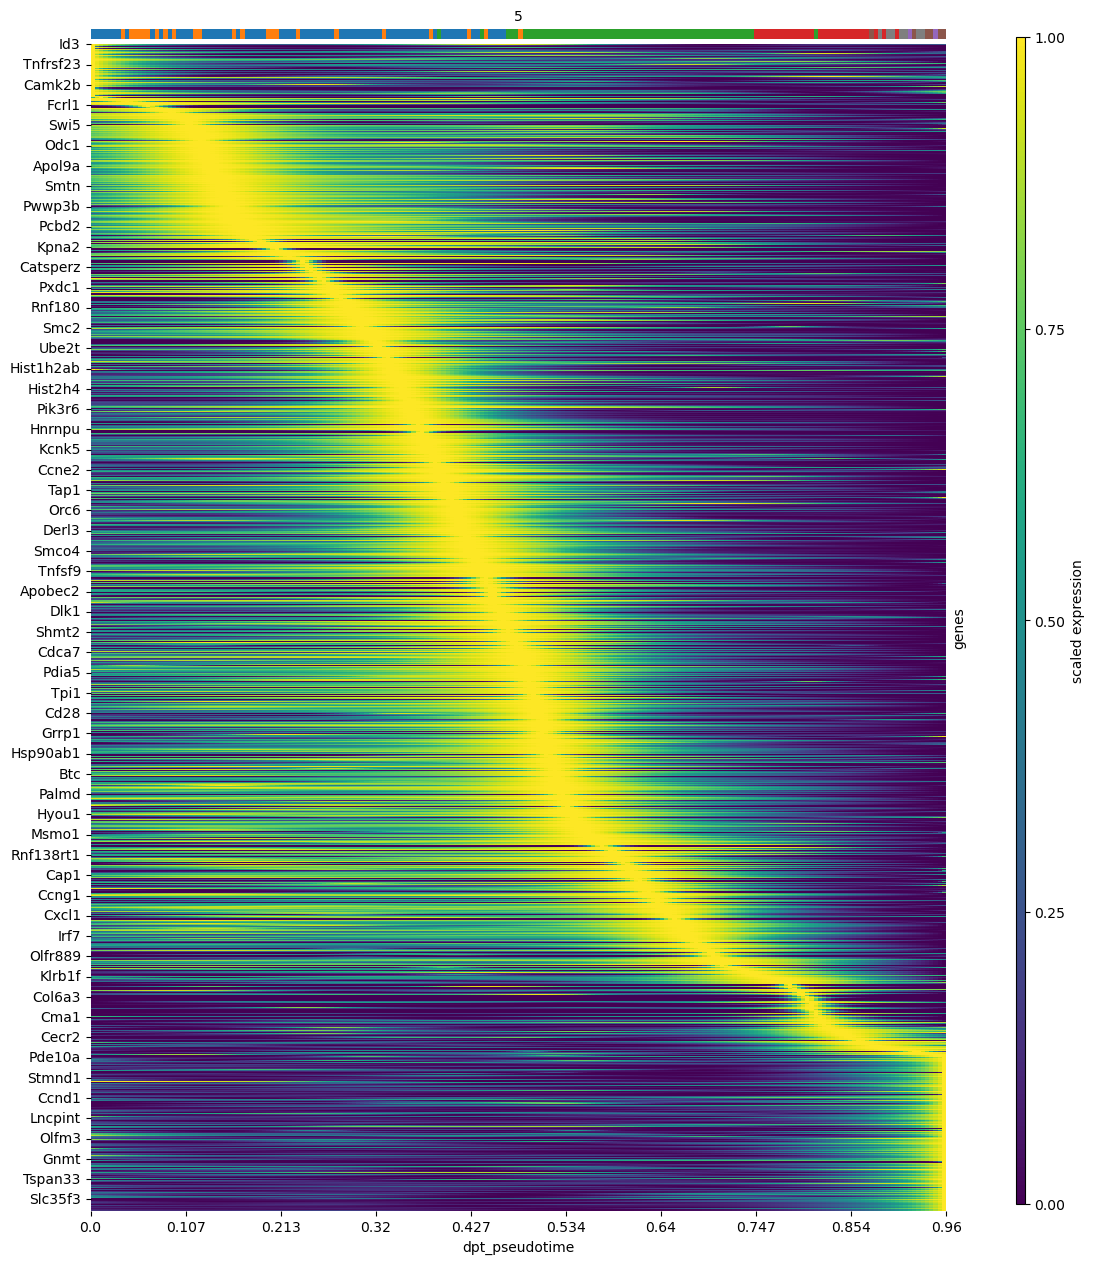

In [ ]:
heatmap_results = cr.pl.heatmap(
    adata,
    model=model,
    lineages="5",
    cluster_key="timepoint",
    show_fate_probabilities=False,
    data_key="log1p_norm",
    genes=adata[:, adata.var["highly_variable"]].var_names,
    time_key="dpt_pseudotime",
    figsize=(12, 15),
    show_all_genes=False,
    cluster_genes=False,
    weight_threshold=(1e-3, 1e-3),
    n_jobs=16,
    return_figure=True,
    return_genes=True,
    return_models=True
)

In [ ]:
gc.collect()

78991

### Cluster gene expression trends

 92%|█████████▏| 1846/2000 [16:09<03:30,  1.36s/gene] 

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


 93%|█████████▎| 1858/2000 [16:25<04:03,  1.72s/gene]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


 97%|█████████▋| 1932/2000 [17:13<00:34,  1.95gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


 98%|█████████▊| 1954/2000 [17:32<00:30,  1.50gene/s]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


 98%|█████████▊| 1964/2000 [17:44<00:37,  1.05s/gene]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


100%|█████████▉| 1990/2000 [18:14<00:35,  3.56s/gene]

did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge
did not converge


100%|██████████| 2000/2000 [18:26<00:00,  1.81gene/s]


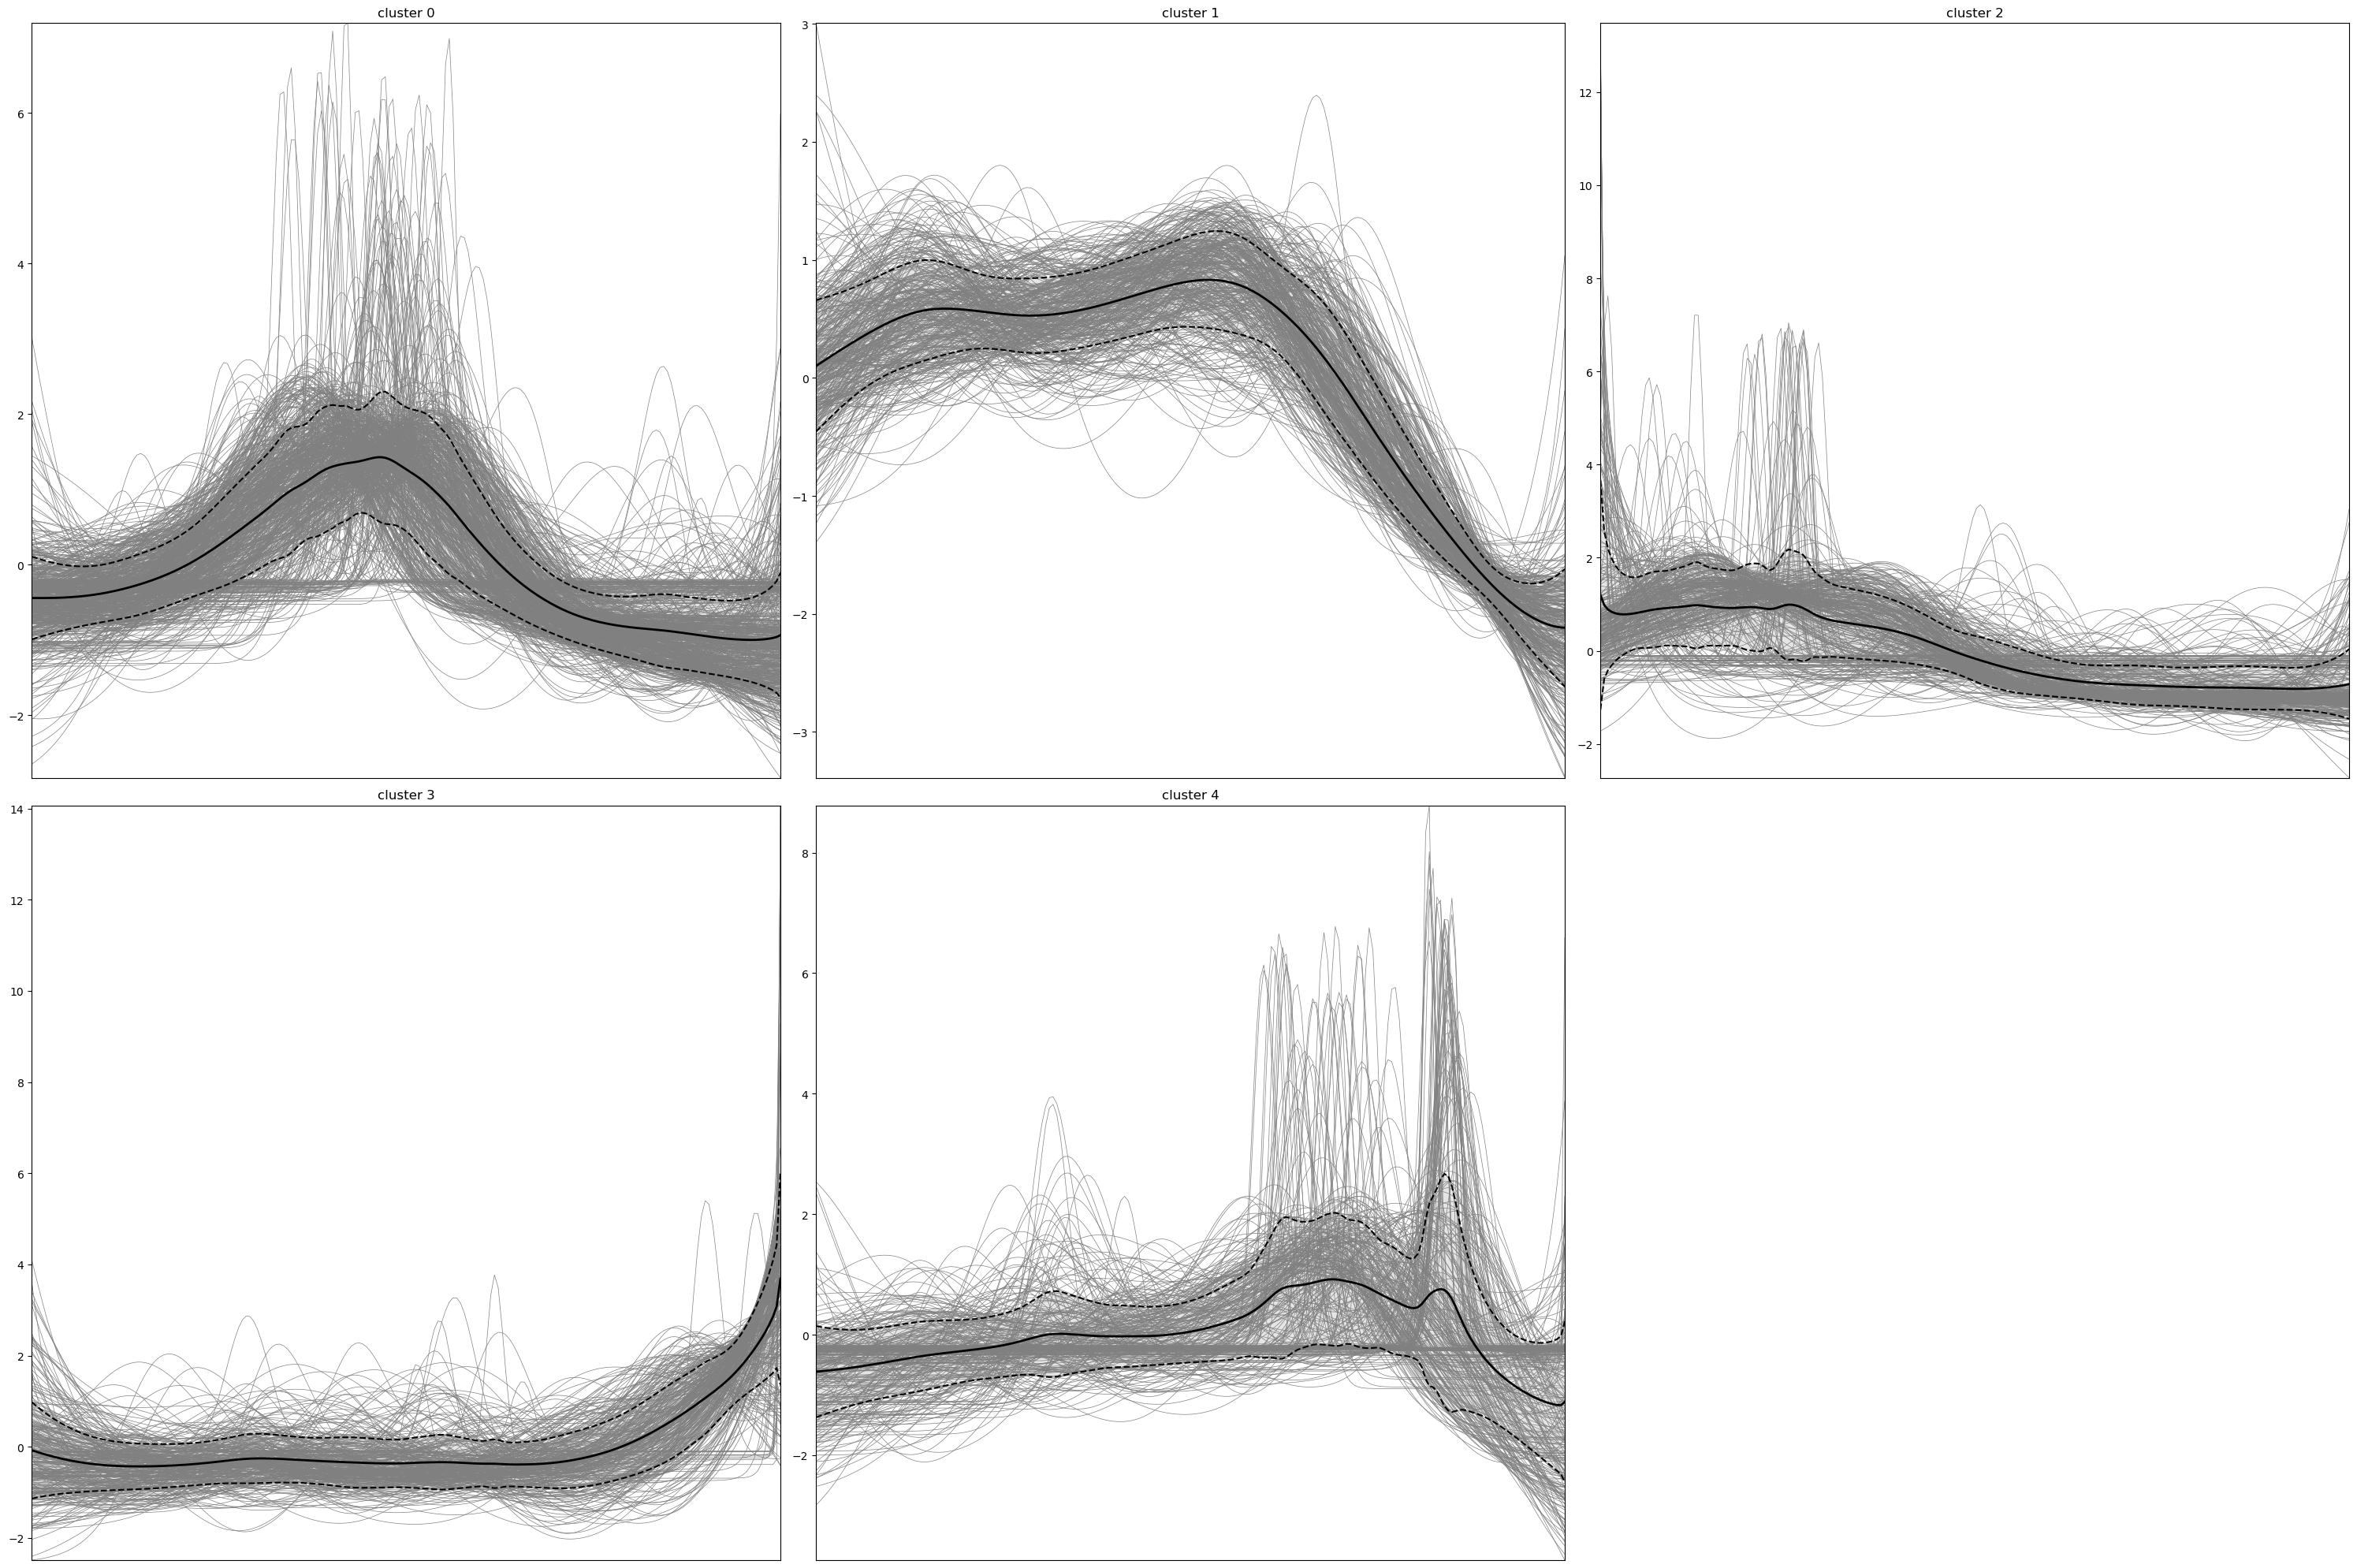

In [ ]:
models = cr.pl.cluster_trends(
    adata,
    model=model,
    lineage="5",
    data_key="log1p_norm",
    genes=adata[:, adata.var["highly_variable"]].var_names,
    time_key="dpt_pseudotime",
    weight_threshold=(1e-3, 1e-3),
    n_jobs=16,
    random_state=0,
    clustering_kwargs={"resolution": 0.2, "random_state": 0},
    neighbors_kwargs={"random_state": 0},
    return_models=True
)

In [ ]:
gdata = adata.uns["lineage_5_trend"].copy()
gdata

AnnData object with n_obs × n_vars = 1842 × 200
    obs: 'clusters'
    var: 'x_test'
    uns: 'pca', 'neighbors', 'clusters'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [ ]:
gdata.obs = gdata.obs.merge(
    right=adata.var[['means', 'variances']], how='left', left_index=True, right_index=True
)

# Figures

In [ ]:
plt.rcParams.update(
    {
        'font.family': 'Arial',
        'font.size': 8,
        'axes.titlesize': 'medium',
        'figure.titlesize': 'medium',
        'figure.labelsize': 'medium',
        'legend.fontsize': 8.0,
    }
)

In [ ]:
umap_dot_size = 250000 / adata.n_obs
print(umap_dot_size)

9.648411871405967


In [ ]:
# Overall UMAP plot sizes, width gets changed if legend is added
plot_width_in = 60/25.4
plot_height_in =45/25.4

# Margin around plot area in inches
margin_left = 0
margin_bottom = 0
margin_top = 6/25.4

# Legend spacer in inches
legend_width_in = 0
# legend_width_in = 1.27/25.4

## Pseudotime

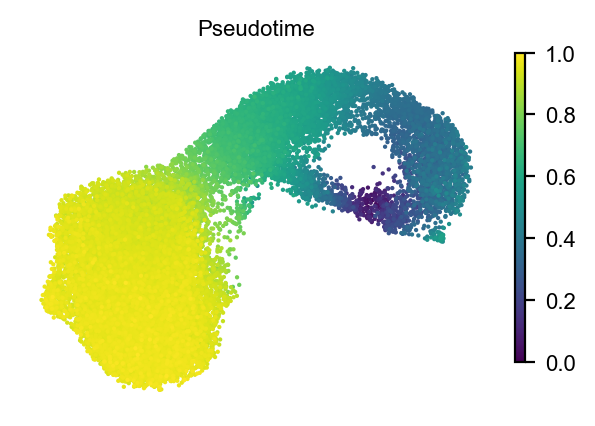

In [ ]:
margin_right = 15 /25.4

fig_width = margin_left + plot_width_in + legend_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout='constrained')
embedding_shuffled(
    adata,
    basis="X_umap",
    color="dpt_pseudotime",
    ax=axes,
    title="Pseudotime",
    size=umap_dot_size,
)

axes.set_position([
    margin_left / fig_width,
    margin_bottom / fig_height,
    plot_width_in / fig_width,
    plot_height_in / fig_height
])

In [ ]:
fig_width = fig.get_figwidth()

## PAGA graph

In [ ]:
embedding = pd.DataFrame(adata.obsm['X_umap'], index=adata.obs_names, columns=['UMAP_1', 'UMAP_2'])

metadata = sc.get.obs_df(adata, keys=['leiden'])

embedding = embedding.merge(metadata, left_index=True, right_index=True)

embedding_medians = embedding.groupby('leiden').median()

In [ ]:
adata.uns['leiden_colors'] = list(leiden_colors.values())[0:8]

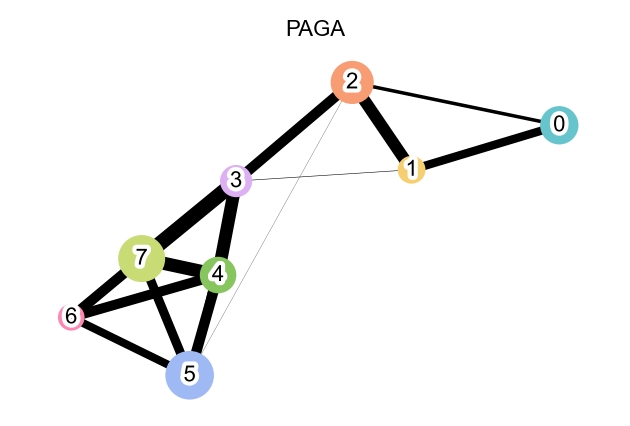

In [ ]:
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout='constrained')

sc.pl.paga(
    adata,
    color = 'leiden',
    pos=np.array(embedding_medians),
    frameon=False,
    title='PAGA',
    show=False,
    ax=axes,
    # node_size_scale=1.8,
    fontsize=8,
    fontweight='normal',
    fontoutline=3,
)

axes.set_position([
    margin_left / fig_width,
    margin_bottom / fig_height,
    (plot_width_in + margin_right) / fig_width,
    plot_height_in / fig_height
])

## Heatmap

In [ ]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']

gene_module_colors = {key: colors[i] for i, key in enumerate(gdata.obs['clusters'].cat.categories)}

In [ ]:
heatmap_gene_trends = heatmap_results[0][0]

In [ ]:
def spread_labels(y_positions, min_dist=50):
    y_positions = np.array(y_positions, dtype=float)
    idx_sort = np.argsort(y_positions)
    y_sorted = y_positions[idx_sort]

    y_adjusted = y_sorted.copy()

    # Loop over all of them and shift them downwards (increasing y) if they are too close
    for i in range(1, len(y_adjusted)):
        if y_adjusted[i] - y_adjusted[i - 1] < min_dist:
            y_adjusted[i] = y_adjusted[i - 1] + min_dist

    # shift all of them back up by the median so that they don't all shift downwards in a cascading effect
    shift = np.median(y_sorted - y_adjusted)
    y_adjusted += shift

    for _ in range(10):
        for i in range(0, len(y_adjusted)-1):
            new_y = y_adjusted[i+1] - min_dist
            # Only move down if there’s extra space and we don’t go below original
            if y_adjusted[i] < new_y and new_y < y_sorted[i]:
                y_adjusted[i] = new_y
            # Otherwise, if there’s extra space but moving to original is possible
            elif y_adjusted[i] < new_y and y_sorted[i] < new_y:
                y_adjusted[i] = y_sorted[i]

    y_final = np.empty_like(y_adjusted)
    y_final[idx_sort] = y_adjusted

    return y_final

In [ ]:
genes_of_interest = [
    "Mcm3",
    "Mcm4",
    "Mcm6",
    "Pole",
    "Tuba1b",
    "Tubb5",
    "Mki67",
    "Spdl1",
    "Plk4",
    "Cd160",
    "Cd27",
    "Ikzf2",
    "Cd69",
    "Ccr7",
    "Cx3cr1",
    "Itga4",
    "S1pr1",
    "Itgae",
    "Itgb7",
    "Csf2",
    "Il13",
    "Xcl1",
    "Jun",
    "Areg",
    "Vegfa",
    "Pdgfa",
    "Tubb3",
    "Tubb2a",
    "Sdc1",
    "Sdc4",
]

y_positions = []

for gene in genes_of_interest:
    y_positions.append(heatmap_results[1][heatmap_results[1]['5'] == gene].index[0])

y_final = spread_labels(y_positions, min_dist=60)

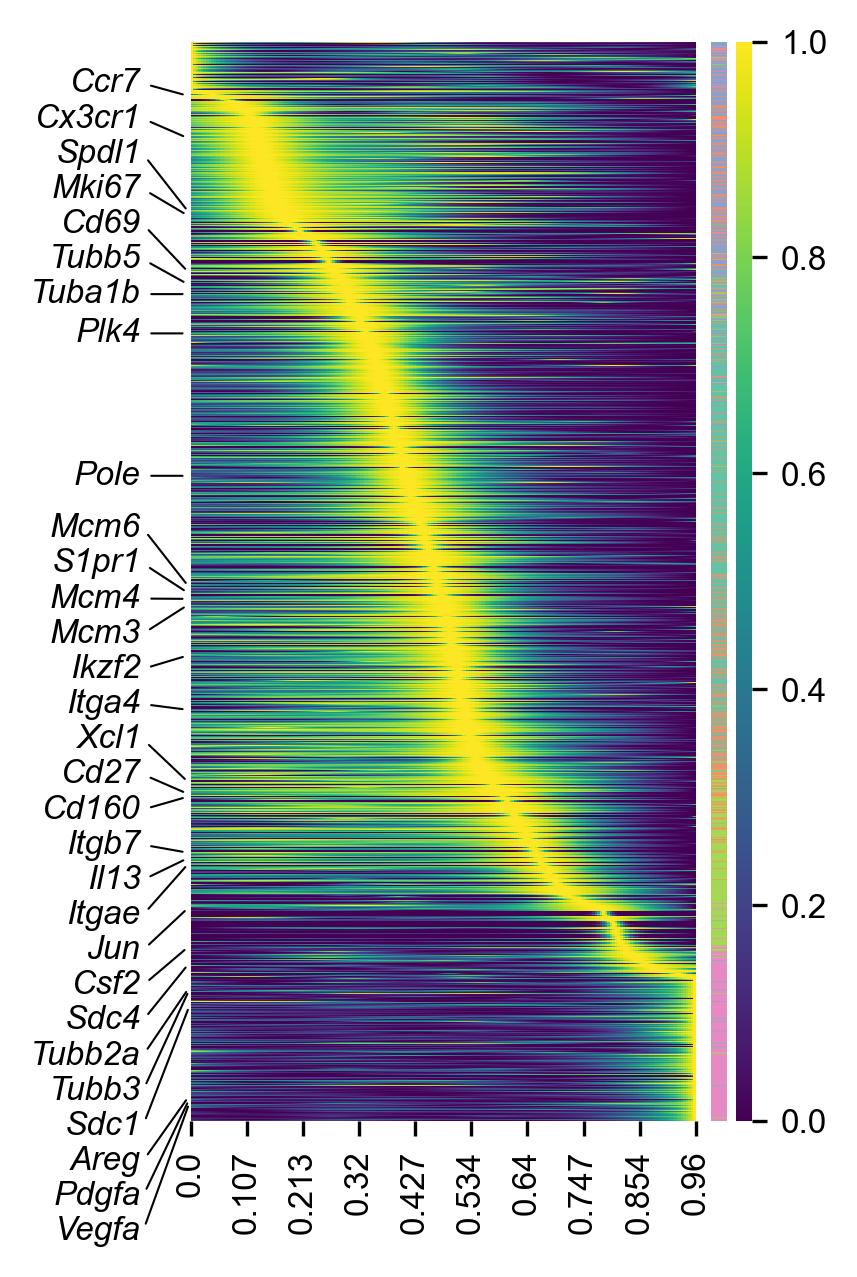

In [ ]:
fig, ax_heatmap = plt.subplots(
    1, 1, figsize=(70 / 25.4, 105.195 / 25.4), dpi=300, layout="constrained"
)

sns.heatmap(
    heatmap_gene_trends.data2d,
    cmap="viridis",
    ax=ax_heatmap,
    cbar_kws={"shrink": 1, "aspect": 70},
)

ax_heatmap.set_ylabel("")
ax_heatmap.set_xticks(heatmap_gene_trends.fig.get_axes()[3].get_xticks())
ax_heatmap.set_xticklabels(heatmap_gene_trends.fig.get_axes()[3].get_xticklabels())
ax_heatmap.set_yticks([])
ax_heatmap.set_yticklabels([])

for orig, shifted, label in zip(
    y_positions, y_final, genes_of_interest
):
    tx, ty = -20, shifted
    ax_heatmap.text(tx, ty, label, ha="right", va="center", fontsize=8, style='italic')

    ax_heatmap.annotate(
        "",
        xy=(0, orig),
        xytext=(tx + 1, ty),
        xycoords="data",
        textcoords="data",
        arrowprops=dict(arrowstyle="-", lw=0.5, color="black", connectionstyle="arc3"),
    )


ax_cluster_colorbar = inset_axes(
    ax_heatmap,
    width="3%",
    height="100%",
    loc="center right",
    bbox_to_anchor=(
        0.06,
        0,
        1,
        1,
    ),
    bbox_transform=ax_heatmap.transAxes,
    borderpad=0,
)

clusters = (
    pd.DataFrame(gdata.obs["clusters"])
    .reindex(heatmap_results[1]["5"])
    .reset_index()
    .rename(columns={"5": "gene"})["clusters"]
)
row_colors = [gene_module_colors.get(num, "black") for num in clusters]

rgb_colors = [mcolors.to_rgb(c) for c in row_colors]

ax_cluster_colorbar.imshow(
    np.array([rgb_colors]).reshape(-1, 1, 3),
    aspect="auto",
)
ax_cluster_colorbar.set_axis_off()

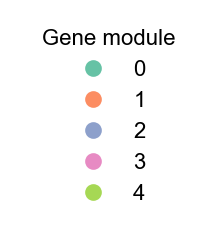

In [ ]:
fig, axes = plt.subplots(
    1,1, figsize=(1, 1), dpi=200
)

handles = [
    mlines.Line2D(
        [],
        [],
        color=color,
        marker="o",
        linestyle="None",
        markersize=5,
        label=label,
    )
    for label, color in gene_module_colors.items()
]

axes.legend(
    handles=handles,
    loc="center left",
    bbox_to_anchor=(0.01, 0.5),
    fontsize=8,
    title="Gene module",
    frameon=False
)
axes.set_axis_off()

## Handpicked genes

In [ ]:
handpicked_genes = ['Tbx21', 'Itgae', 'Cd69', 'Areg']

genes_to_module = gdata.obs["clusters"].loc[handpicked_genes]

100%|██████████| 4/4 [00:01<00:00,  3.19gene/s]
[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0
<positron-console-cell-160>:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


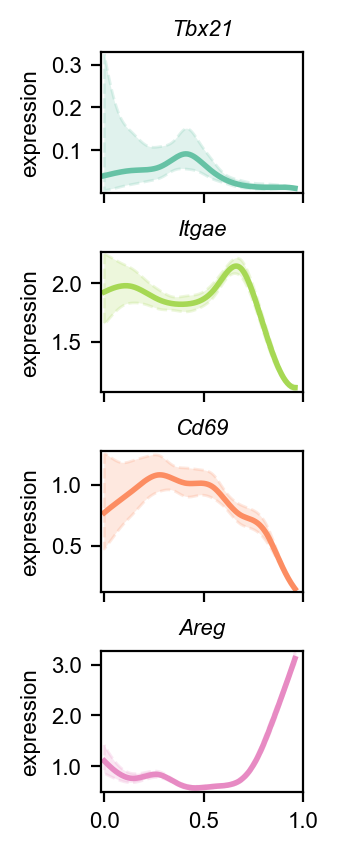

In [ ]:
p1 = cr.pl.gene_trends(
    adata,
    model=model,
    lineages=["5"],
    data_key="log1p_norm",
    genes=handpicked_genes,
    same_plot=True,
    ncols=1,
    hide_cells=True,
    time_key="dpt_pseudotime",
    weight_threshold=(1e-3, 1e-3),
    return_figure=True,
    figsize=(40/25.4, 105.195/25.4),
    dpi=200,
    legend_loc=None,
)

for i, axes in enumerate(p1.get_axes()):
    axes.set_xticks([0,0.5,1])
    axes.set_title(axes.get_title(), style='italic')

    axes.get_lines()[0].set_color(gene_module_colors[genes_to_module.iloc[i]])
    axes.collections[0].set_facecolor(gene_module_colors[genes_to_module.iloc[i]])
    axes.collections[0].set_edgecolor(gene_module_colors[genes_to_module.iloc[i]])

p1.get_axes()[3].set_xticks([0,0.5,1])
p1.get_axes()[3].set_xlabel('')

p1.get_axes()[3].set_yticklabels([0,1.0,2.0,3.0])

p1.set_constrained_layout(True)

# Supplementary Figures

## Initial states

Text(0.5, 1.0, 'Initial state')

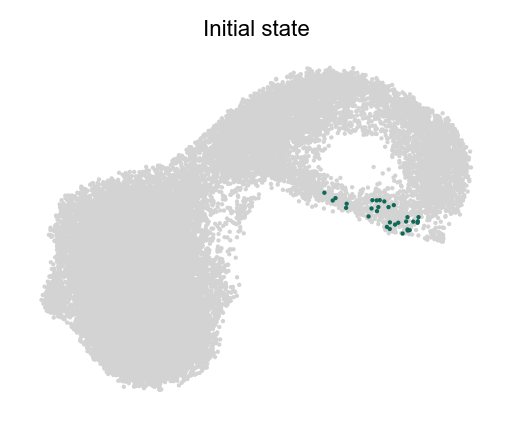

In [ ]:
margin_right = 0

fig_width = margin_left + plot_width_in + legend_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout='constrained')

embedding_shuffled(
    adata,
    basis="X_umap",
    ax=axes,
    size=umap_dot_size,
)

embedding_shuffled(
    adata[adata.obs['init_states_fwd'] == '0_1'],
    basis="X_umap",
    ax=axes,
    size=umap_dot_size,
    color='init_states_fwd',
    legend_loc=None
)

axes.set_position([
    margin_left / fig_width,
    margin_bottom / fig_height,
    plot_width_in / fig_width,
    plot_height_in / fig_height
])

axes.set_title('Initial state')

## Terminal states

In [ ]:
terminal_states_colors = {
    '5': '#5ab4ac',
    '0_2': '#d8b365',
}

/home/david/anaconda3/envs/cellrank/lib/python3.13/site-packages/scanpy/plotting/_utils.py:481: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


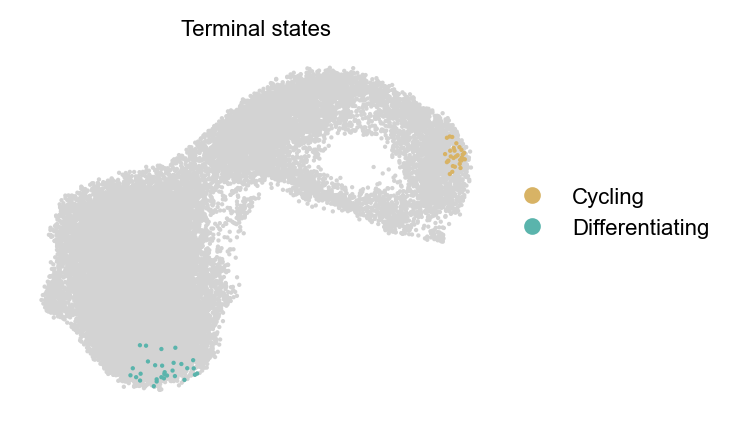

In [ ]:
margin_right = 29/25.4

fig_width = margin_left + plot_width_in + legend_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout='constrained')

embedding_shuffled(
    adata,
    basis="X_umap",
    ax=axes,
    size=umap_dot_size,
)

embedding_shuffled(
    adata[~adata.obs['term_states_fwd'].isna()],
    basis="X_umap",
    ax=axes,
    size=umap_dot_size,
    color='term_states_fwd',
    palette=terminal_states_colors,
    legend_fontsize=8,
    legend_loc=None
)

axes.set_position([
    margin_left / fig_width,
    margin_bottom / fig_height,
    plot_width_in / fig_width,
    plot_height_in / fig_height
])

axes.set_title('Terminal states')

markersize=5

handles = [
    mlines.Line2D([], [], color=terminal_states_colors['0_2'],
                  marker='o', linestyle='None',
                  markersize=markersize, label='Cycling'),
    mlines.Line2D([], [], color=terminal_states_colors['5'],
                  marker='o', linestyle='None',
                  markersize=markersize, label='Differentiating'),
]
fig.legend(
    handles = handles,
    labels=['Cycling', 'Differentiating'],
    loc='center right',
    frameon=False,
)

## Gene modules

In [ ]:
df_gene_modules = pd.DataFrame(
    gdata.X,
    index=gdata.obs_names,
    columns=gdata.var_names
)

df_gene_modules['gene_module'] = gdata.obs['clusters']

In [ ]:
def plot_gene_module_with_colorbar(data, gs, title=None, color=None, rgb_colseries=None):

    gs_main = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=gs, height_ratios=[20, 1]
    )

    ax_lineplot = fig.add_subplot(gs_main[0])
    ax_colorbar = fig.add_subplot(gs_main[1])

    if color is None:
        color = 'gray'

    mean = data.mean()
    std = data.std()

    for row in data.iterrows():
        ax_lineplot.plot(row[1], color=color, alpha=0.1)
    ax_lineplot.plot(mean, color='black', linewidth=2)
    ax_lineplot.plot(mean-std, color='black', linewidth=1, linestyle='--')
    ax_lineplot.plot(mean+std, color='black', linewidth=1, linestyle='--')
    ax_lineplot.fill_between(range(len(mean)), mean - std, mean + std, color='black', alpha=0.1)

    ax_lineplot.set_xticks([])
    ax_lineplot.set_xticklabels([])

    if title is not None:
        ax_lineplot.set_title(title)
    if rgb_colseries is not None:
        ax_colorbar.imshow(
            np.array([rgb_colseries]), 
            aspect="auto",
        )

        ax_colorbar.set_axis_off()

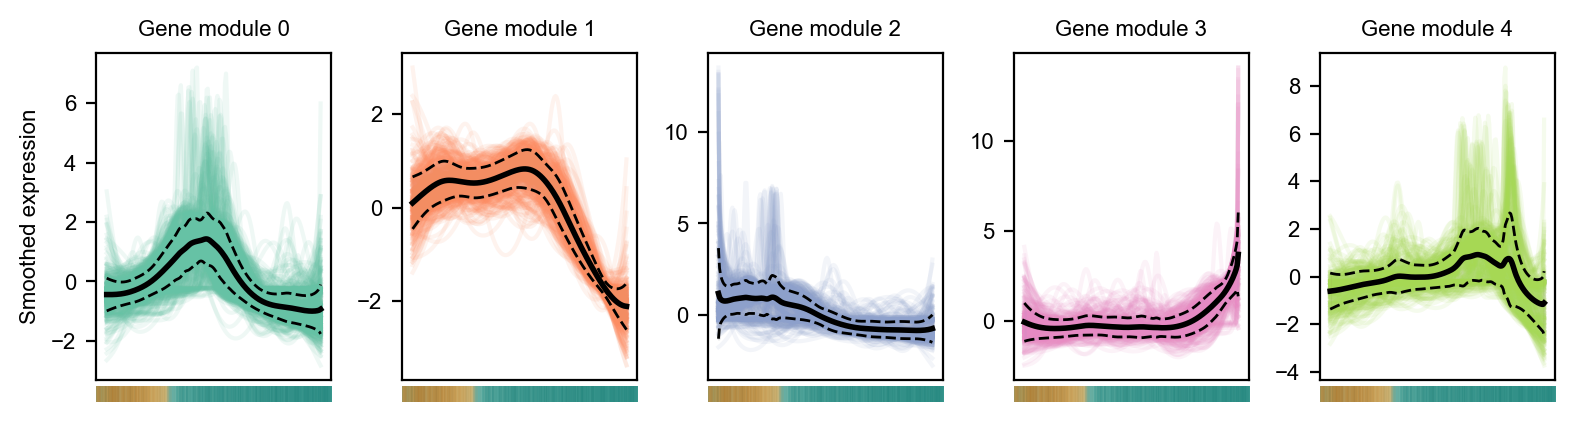

In [ ]:
fig = plt.figure(figsize=(199.208/25.4, 51/25.4), dpi=200)

fig.subplots_adjust(
    left=0.06,
    right=0.99,
    bottom=0.01,
    top=0.88, 
    wspace=0.3,
    hspace=0.03
)

gs_main = gridspec.GridSpec(1, 5, figure=fig, )

tp_colbar = heatmap_gene_trends.col_colors[0]

for i, gene_module in enumerate(df_gene_modules["gene_module"].cat.categories):

    plot_gene_module_with_colorbar(
        df_gene_modules[df_gene_modules["gene_module"] == gene_module].drop(
            "gene_module", axis=1
        ),
        gs = gs_main[i],
        title=f'Gene module {gene_module}',
        color=gene_module_colors[gene_module],
        rgb_colseries=tp_colbar
    )

fig.axes[0].set_ylabel("Smoothed expression")